# Hemorage_Detection
Detecting intracranial hemorrhage using DCNN
Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem requiring rapid and often intensive medical treatment. For example, intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.

Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming. 

The objective is to detect acute intracranial hemorrhage and its subtypes (epidural,intraparenchymal,intraventricular,subarachnoid,subdural) using a DCNN.

![](1.png)
![](2.png)


What are the types of ICH?

There are four types of ICH:

-    epidural hematoma
-    subdural hematoma
-    subarachnoid hemorrhage
-    intracerebral hemorrhage

Epidural hematoma

A hematoma is a collection of blood, in a clot or ball, outside of a blood vessel. An epidural hematoma occurs when blood accumulates between your skull and the outermost covering of your brain.

It typically follows a head injury, and usually with a skull fracture. High-pressure bleeding is a prominent feature. If you have an epidural hematoma, you may briefly lose consciousness and then regain consciousness.
Subdural hematoma

A subdural hematoma is a collection of blood on the surface of your brain.

It’s typically the result of your head moving rapidly forward and stopping, such as in a car accident. However, it could also suggest abuse in children. This is the same type of movement a child experiences when being shaken.

A subdural hematoma is more common than other ICHs in older people and people with history of heavy alcohol use.
Intracerebral hemorrhage

Intracerebral hemorrhage is when there’s bleeding inside of your brain. This is the most common type of ICH that occurs with a stroke. It’s not usually the result of injury.

A prominent warning sign is the sudden onset of neurological deficit. This is a problem with your brain’s functioning. The symptoms progress over minutes to hours. They include:

-    headache
-    difficulty speaking
-    nausea
-    vomiting
-    decreased consciousness
-    weakness in one part of the body
-    elevated blood pressure


Image credit: By SVG by Mysid, original by SEER Development Team [1], Jmarchn - Vectorized in Inkscape by Mysid, based on work by SEER Development Team, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=10485059

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy as sp
import os

BasePath = os.path.abspath('/home/andrew/Documents/Machine Learninng/ItraCranialProject/rsna-intracranial-hemorrhage-detection/')
df = pd.read_csv(BasePath + '/stage_1_train.csv')
df.head(5)
dfOriginal = df.copy()

## Organising the data

The training data is provided as a set of image Ids and multiple labels, one for each of five sub-types of hemorrhage, plus an additional label for any, which should always be true if any of the sub-type labels is true.

There is also a target column, Label, indicating the probability of whether that type of hemorrhage exists in the indicated image.

There will be 6 rows per image Id. Therefore we need to separate the data into a more readable format. We will separate the filename from the ID and class of hemorrhage so that the ID is the index, the class as the columns and the labels as values. 

In [2]:
split = df['ID'].str.split('_', expand = True)
df['Hemorrhage'] = split[2]
df['Patient'] = split[0] + '_' + split[1]
df = df.drop('ID', axis = 1)

df.head(2)

,Label,Hemorrhage,Patient
0,0,epidural,ID_63eb1e259
1,0,intraparenchymal,ID_63eb1e259


In [3]:
df.Label.isnull().sum()

0

In [4]:
df = df[['Label','Patient','Hemorrhage']].drop_duplicates().pivot_table(
    index = 'Patient', columns = 'Hemorrhage', values = 'Label')
df = pd.DataFrame(df.to_records())
df.head(2)


,Patient,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0


# Inspecting images


Overview of DICOM files and medical images

Medical images are stored in a special format known as DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. In Python, one popular library to access and manipulate DICOM files is the pydicom module. To use the pydicom library, first find the DICOM file for a given patientId by simply looking for the matching file in the stage_1_train_images/ folder, and the use the pydicom.read_file() method to load the data:


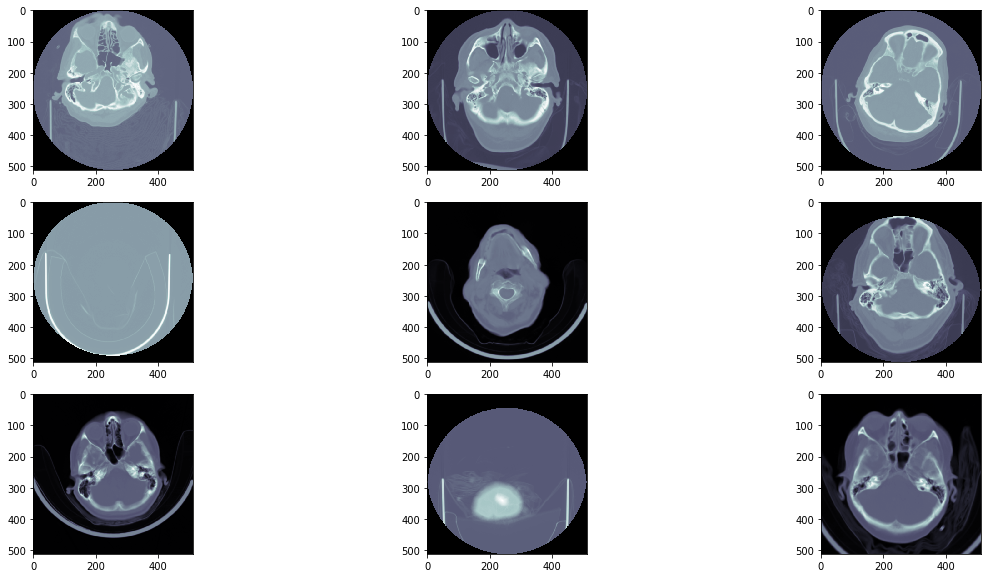

In [5]:
import matplotlib.image as pltimg
import pydicom

# prints 25 * 25 dicom Images
import pydicom
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(20, 10))
rows = 3; columns = 3;
Train_images = os.listdir(BasePath + '/stage_1_train_images/')
for i in range(rows * columns):
    img = pydicom.dcmread(BasePath + '/stage_1_train_images/' + Train_images[i* 100+1])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.pixel_array, cmap = plt.cm.bone)
    fig.add_subplot

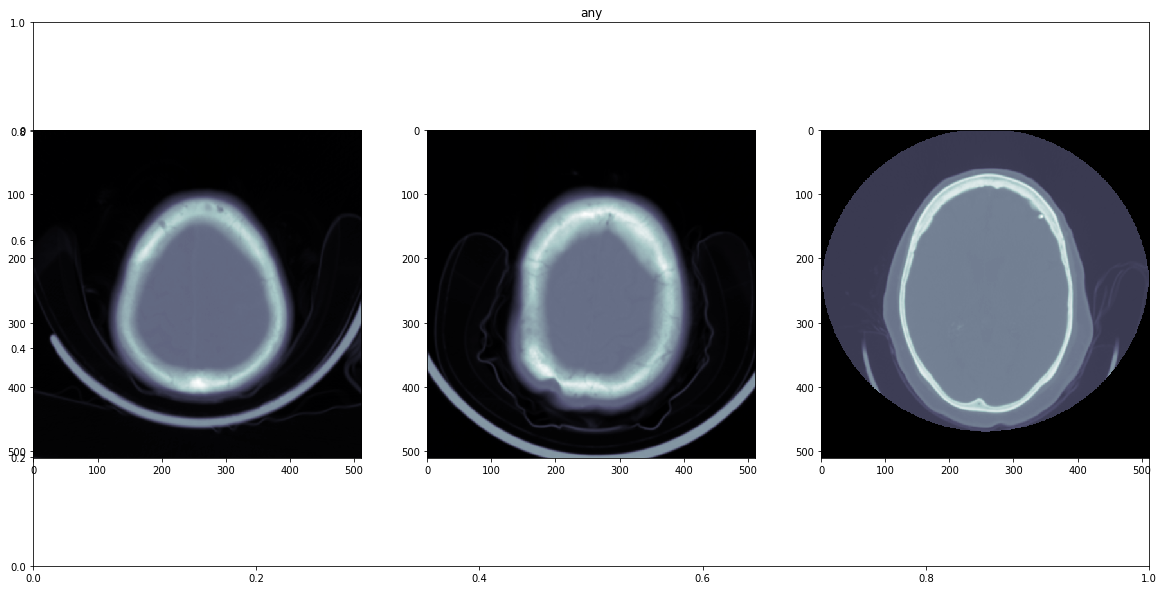

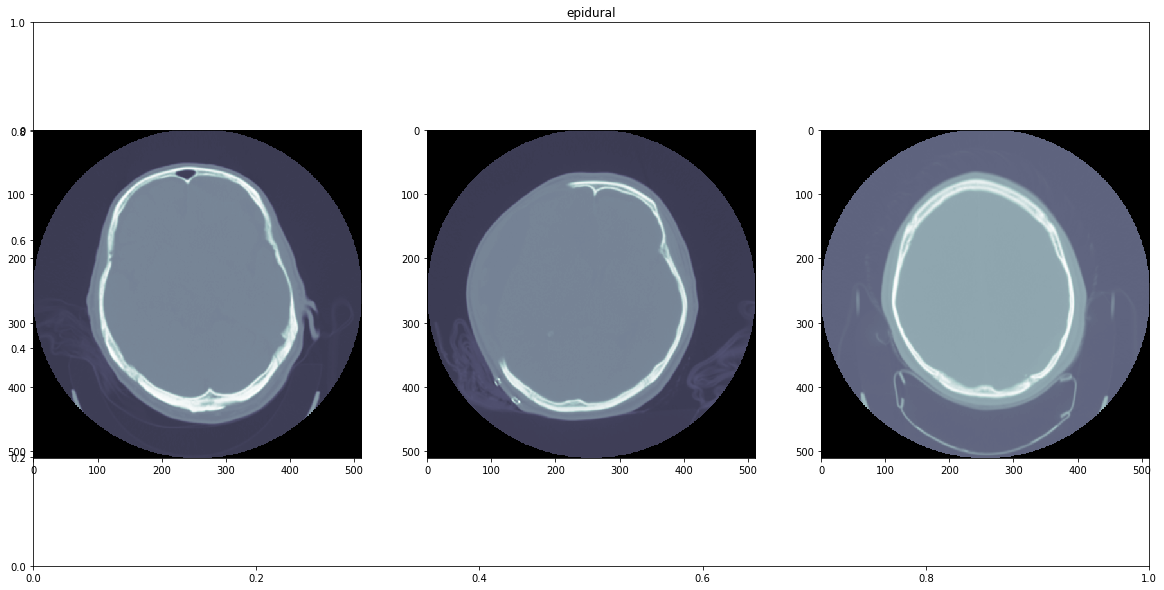

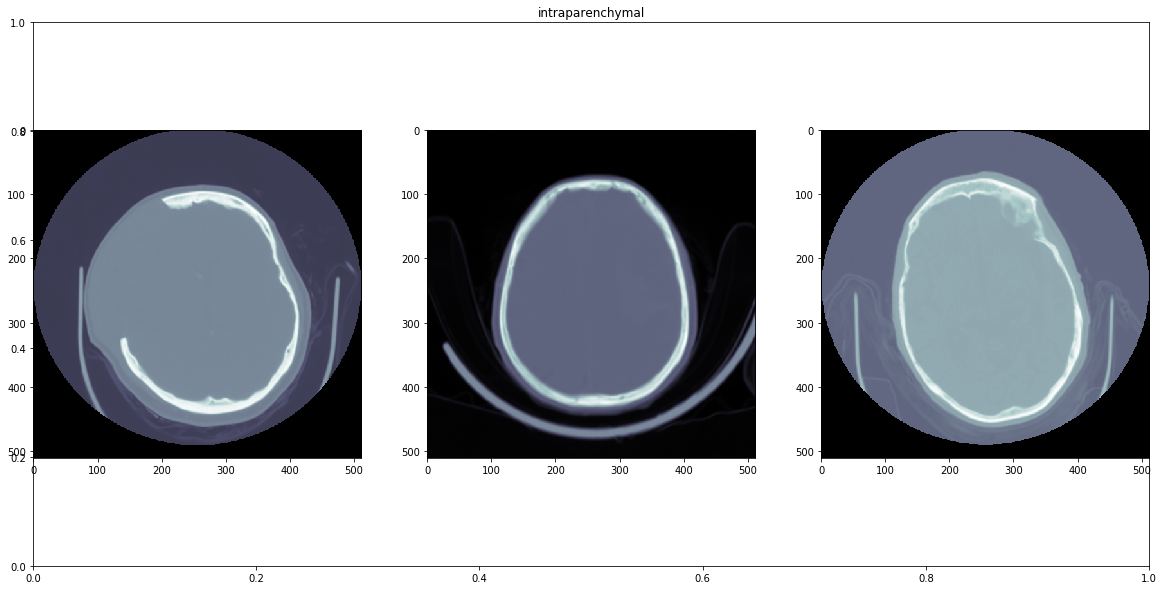

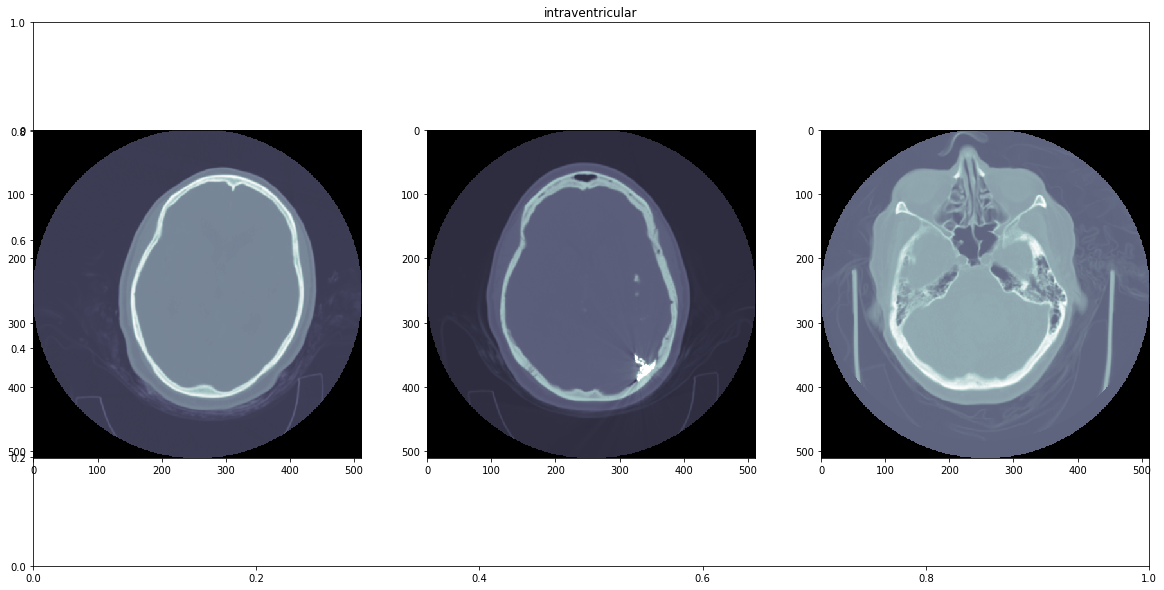

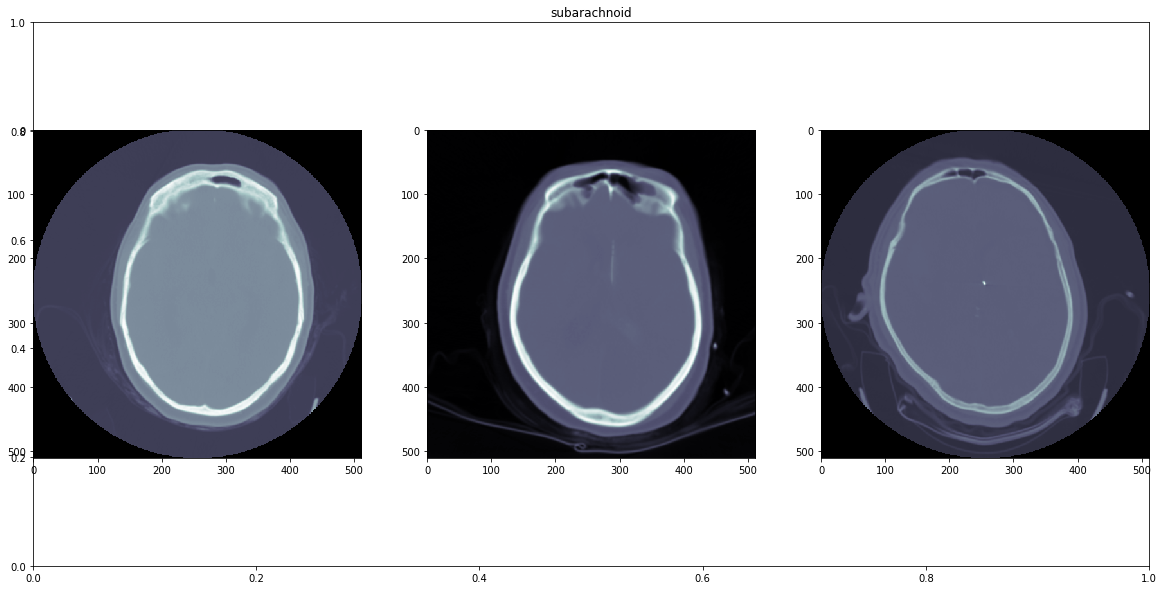

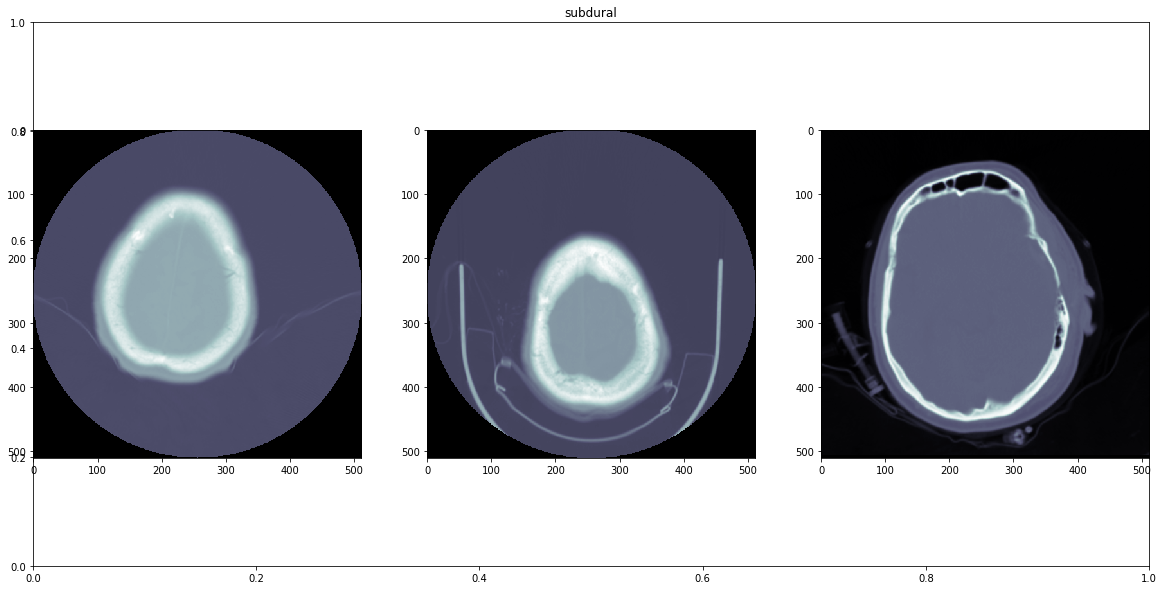

In [6]:
plot_cols = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']

for col in plot_cols:
    
    fig = plt.figure(figsize=(20, 10))
    rows = 1; columns = 3;
    Train_images = list(df.loc[df[col]==1, 'Patient'])
    plt.title(col)
    
    for i in range(rows * columns):
        img = pydicom.dcmread(BasePath + '/stage_1_train_images/' + Train_images[i* 100+1]+ '.dcm')
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img.pixel_array, cmap = plt.cm.bone)
        fig.add_subplot


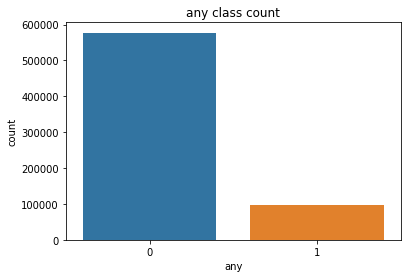

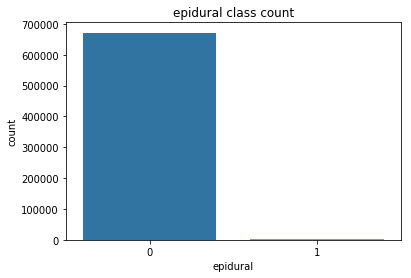

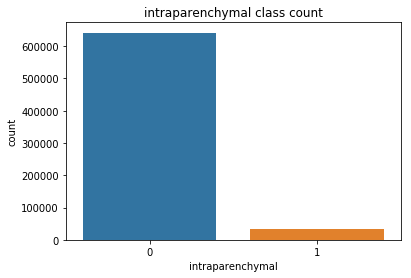

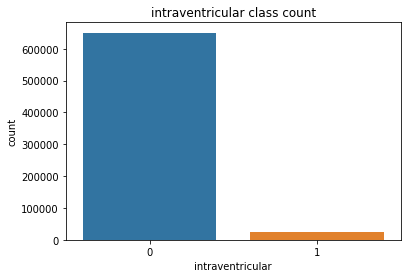

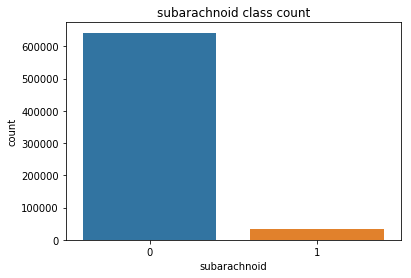

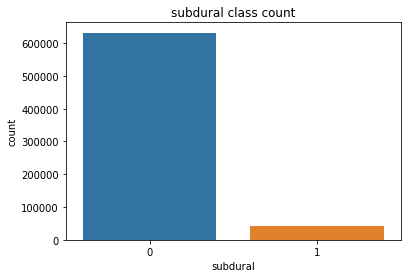

In [7]:
for i_col in plot_cols:
    plt.figure()
    ax = sns.countplot(df[i_col])
    ax.set_title(i_col + ' class count')

Dropping of corrupted image from dataset as mentioned in https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109701#latest-640597


# Preprocessing Data part 3

In [8]:
# Dropping of corrupted image from dataset as mentioned in https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109701#latest-640597
df = df.drop(list(df['Patient']).index('ID_6431af929'))

In [9]:
import keras
from keras.layers import Dense, Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Input,BatchNormalization,AveragePooling2D,LeakyReLU,ZeroPadding2D,Add
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

# Shuffle and split data into train validation and y labels

df = df.sample(frac = 1).reset_index(drop = True)
train_df, val_df = train_test_split(df, test_size = 0.03, random_state = 42)
batch_size = 64

y_train = train_df[['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]
y_val = val_df[['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]
train_patients = list(train_df['Patient'])
val_patients = list(val_df['Patient'])

Using TensorFlow backend.


In [10]:
# Extract img data Read dicom image and resize using cv2

def readDicom(train_patients):
    img_dic = pydicom.dcmread(train_patients)
    img = img_dic.pixel_array
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    return img

def GenerateImageTrain(train_patients):
    num_batches = int(np.ceil(len(train_patients)/batch_size))
    while True:
        for i in range(num_batches):
            batches = train_patients[i*batch_size: (i+1)*batch_size] 
            x_batch = np.array([readDicom(BasePath + '/stage_1_train_images/'+ j +'.dcm') for j in tqdm(batches)])
            x_batch = np.reshape(x_batch.shape[0], x_batch.shape[1], x_batch.shape[2], 1)
            y_batch = y_train[i*batch_size: (i+1)*batch_size] 
            yield x_batch, y_batch
            
def GenerateImageTest (train_patients):
    num_batches = int(np.ceil(len(train_patients)/batch_size))
    while True:
        for i in range(num_batches):
            batches = train_patients[i*batch_size: (i+1)*batch_size] 
            x_batch = np.array([readDicom(BasePath + '/stage_1_train_images/'+ j +'.dcm') for j in tqdm(batches)])
            x_batch = np.reshape(x_batch.shape[0], x_batch.shape[1], x_batch.shape[2], 1)
            y_batch = y_train[i*batch_size: (i+1)*batch_size] 
            yield x_batch, y_batch

In [11]:
# Generate Train Images and Validation
TrainData = GenerateImageTrain(train_patients)
x_val = np.array([readDicom(BasePath + '/stage_1_train_images/'+ j +'.dcm') for j in tqdm(val_patients)])


100%|██████████| 20228/20228 [00:52<00:00, 385.40it/s]


# Log Loss part 4

In [12]:
# loss function definition courtesy https://www.kaggle.com/akensert/resnet50-keras-baseline-model
from keras import backend as K
def logloss(y_true,y_pred):      
    eps = K.epsilon()
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    y_pred = K.clip(y_pred, eps, 1.0-eps) # clips the values minimum of epsilon 1e-07 to max 1- epsilon

    #compute logloss function (vectorised)  -(ylog(p) +(1-y) * log(1-p)* W)
    out = -( y_true *K.log(y_pred)*class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred)*class_weights) 
    return K.mean(out, axis=-1)

def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for the this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1) # expands dimensions 
        return K.sum(K.dot(arr, weights), axis=1) / scl # sum x*1/ sum w
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """      
    
    eps = K.epsilon()
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(y_true*K.log(y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss,class_weights)
    
    return K.mean(loss_samples)

# Building a CNN part 5


In [13]:
# Inception Block from Inception V4

def InceptionBlock1(Input, filterTower1_1, filterTower1_2, filterTower2_1, filterTower2_2,
                   filterTowerMpool3, filterTower3):
    Tower1 = Conv2D(filterTower1_1, (1,1), padding = 'same', activation = 'relu')(Input)
    Tower1 = Conv2D(filterTower1_2, (3,3), padding = 'same', activation = 'relu')(Tower1)
    Tower2 = Conv2D(filterTower2_1, (1,1), activation = 'relu')(Input)
    Tower2 = Conv2D(filterTower2_2, (3,3), padding = 'same', activation = 'relu')(Tower2)
    MaxPoolTower = MaxPooling2D((3,3), strides = (1,1), padding = 'same')(Input)
    TowerMpool = Conv2D(filterTowerMpool3, (1,1), padding = 'same', activation='relu')(MaxPoolTower)
    Tower3 = Conv2D(filterTower3, (1,1), padding = 'same', activation = 'relu')(Input)
    Output = keras.layers.concatenate([Tower1, Tower2, TowerMpool, Tower3])
    Output = Activation('relu')(Output)
    return Output

def InceptionBlock2(Input, filterTower1_1, filterTower1_2, filterTower1_3, filterTower2_1, 
                    filterTower2_2, filterTower2_3, filterTower2_4, filterTower2_5, 
                   filterShortcut, maxPoolFilterTower):
    Tower1 = Conv2D(filterTower1_1, (1,1), padding = 'same', activation = 'relu')(Input)
    Tower1 = Conv2D(filterTower1_2, (3,3), padding = 'same', activation = 'relu')(Tower1)
    Tower1 = Conv2D(filterTower1_2, (3,3), padding = 'same', activation = 'relu')(Tower1)
    Tower2 = Conv2D(filterTower2_1, (1,1), activation = 'relu')(Input)
    Tower2 = Conv2D(filterTower2_2, (7,1), padding = 'same', activation = 'relu')(Tower2)
    Tower2 = Conv2D(filterTower2_3, (1,7), padding = 'same', activation = 'relu')(Tower2)
    Tower2 = Conv2D(filterTower2_4, (7,1), padding = 'same', activation = 'relu')(Tower2)
    Tower2 = Conv2D(filterTower2_5, (1,7), padding = 'same', activation = 'relu')(Tower2)
    MaxPoolTower = MaxPooling2D((3,3), strides = (1, 1), padding = 'same')(Input)
    TowerMpool = Conv2D(maxPoolFilterTower, (1,1), padding = 'same', activation='relu')(MaxPoolTower)
    ShortCut = Conv2D(filterShortcut, (1,1), padding = 'same', activation = 'relu')(Input)
    Output = keras.layers.concatenate([ShortCut, Tower1, Tower2, TowerMpool])
    Output = Activation('relu')(Output)
    return Output

# Reduction Block for Inception Block 2                    

def reductionBlock(Input, filterTower1_1, filterTower1_2, filterTower2_1, 
                    filterTower2_2, filterTower2_3, filterTower2_4):
    Tower1 = Conv2D(filterTower1_1, (1,1), padding = 'valid', activation = 'relu')(Input)
    Tower1 = Conv2D(filterTower1_2, (3,3), padding = 'valid', activation = 'relu')(Tower1)
    Tower2 = Conv2D(filterTower2_1, (1,1), activation = 'relu')(Input)
    Tower2 = Conv2D(filterTower2_2, (1,7), padding = 'valid', activation = 'relu')(Tower2)
    Tower2 = Conv2D(filterTower2_3, (7,1), padding = 'valid', activation = 'relu')(Tower2)
    Tower2 = Conv2D(filterTower2_4, (3,3), padding = 'valid', activation = 'relu')(Tower2)
    MaxPoolTower = MaxPooling2D((3,3),strides = (1,1), padding = 'valid')(Input)
    Output = keras.layers.concatenate([Tower1, Tower2, MaxPoolTower], axis = 3)
    return Output

In [15]:
# Identity Block

def IdentityBlock(Input, Filters):
    F1, F2, F3 = Filters
    x =  Conv2D(F1, (1,1), strides = 1, padding = 'valid', kernel_initializer=glorot_uniform(seed=0))(Input)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    x =  Activation('relu')(x)
    x =  Conv2D(F2, (3,3), strides = 1, padding = 'same', kernel_initializer=glorot_uniform(seed=0))(x)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    x =  Activation('relu')(x)
    x =  Conv2D(F3, (1,1), strides = 1, padding = 'valid', kernel_initializer=glorot_uniform(seed=0))(x)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    ShortCut = Input
    x =  Add()([x, ShortCut])
    x =  Activation('relu')(x)


In [16]:
def ConvolutionalBlock(Input, Filters):
    F1, F2, F3 = Filters
    x =  Conv2D(F1, (1,1), strides = 1, padding='valid', 
                kernel_initializer='he_normal')(Input)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    x =  Activation('relu')(x)
    x =  Conv2D(F2, (3,3), strides = 1, padding='same', 
                kernel_initializer='he_normal')(x)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    x =  Activation('relu')(x)
    x =  Conv2D(F3, (1,1), strides = 1, padding = 'valid',
                kernel_initializer='he_normal')(x)
    x =  BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(x)
    x =  Activation('relu')(x)
    ShortCut = Conv2D(F3, (1,1), strides = 1, padding='valid',
                      kernel_initializer='he_normal')(Input)
    ShortCut = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(ShortCut)
    x =  Add()([x, ShortCut])
    x =  Activation('relu')(x)
    return x

In [ ]:
# Model 1

#Input Layer

img_input = Input((64, 64, 1))
x = Conv2D(filters = 3, kernel_size=(1,1), strides=(1,1))(img_input)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = ZeroPadding2D((3, 3))(x)

#Layer 2
x = Conv2D(64, (7,7), strides=(2,2), kernel_initializer=glorot_uniform(seed=0))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides = (2, 2))(x)

#Layer 3
x = ConvolutionalBlock(x, Filters=[64, 64, 256])
x = IdentityBlock(x, Filters=[64, 64, 256])
x = IdentityBlock(x, Filters=[64, 64, 256])
x = IdentityBlock(x, Filters=[64, 64, 256])

#Layer 4
x = ConvolutionalBlock(x, Filters=[128, 128, 512])
x = IdentityBlock(x, Filters=[128, 128, 512])
x = IdentityBlock(x, Filters=[128,   128, 512])
x = IdentityBlock(x, Filters=[128, 128, 512])
x = IdentityBlock(x, Filters=[128, 128, 512])

#Layer 5
x = ConvolutionalBlock(x, Filters=[256, 256, 1024])
x = IdentityBlock(x, Filters=[256, 256, 1024])
x = IdentityBlock(x, Filters=[256, 256, 1024])
x = IdentityBlock(x, Filters=[256, 256, 1024])
x = IdentityBlock(x, Filters=[256, 256, 1024])
x = IdentityBlock(x, Filters=[256, 256, 1024])

#Layer 6
x = ConvolutionalBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])
x = IdentityBlock(x, Filters=[512, 512, 2048])

#Average Pool
x = AveragePooling2D(pool_size=(2,2), padding = 'same')(x)

#Output Layer
x = Flatten()(x)
out = Dense(6, activation='sigmoid')(x)



In [ ]:
model = Model(inputs = img_input,  outputs = out, name = 'Model 1')

model.compile(optimizer='Adam',loss = logloss,metrics=[weighted_loss])
model.summary()
history_conv = model.fit_generator(TrainData,steps_per_epoch=500,
                                   epochs=20,validation_data = (x_val,y_val),verbose = False)



In [ ]:
testInfo = pd.read_csv(basePath+'/stage_1_sample_submission.csv')
splitData = testInfo['ID'].str.split('_', expand = True)
testInfo['Hemorrhage'] = splitData[2]
testInfo['Patient'] = splitData[0] + '_' + splitData[1]
testInfo = testInfo.drop(columns=['ID'],axis=1)
del splitData
Final_testInfo = testInfo[['Patient', 'Hemorrhage','Label']].drop_duplicates().Final_table(index = 'fileName',columns=['class'], values='Label')
Final_testInfo = pd.DataFrame(Final_testInfo.to_records())
test_files = list(Final_testInfo['Patient'])
testDataGenerator = generateTestImageData(test_files)
temp_pred = model_conv.predict_generator(testDataGenerator,steps = Final_testInfo.shape[0]/batch_size,verbose = True)
